## Step 2: Training a simple model

In [1]:
import os
import time
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

from wholeslidedata.interoperability.detectron2.iterator import WholeSlideDetectron2Iterator
from wholeslidedata.interoperability.detectron2.trainer import WholeSlideDectectron2Trainer
from wholeslidedata.interoperability.detectron2.predictor import Detectron2DetectionPredictor
from wholeslidedata.iterators import create_batch_iterator
from utils.vis import plot_boxes, FocalLoss

from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model

from utils.loss import MyFocalROIHeads 

Setting up the training configuration and parameters (can also be defined in a separate yaml file).

In [2]:
user_config = {
    'wholeslidedata': {
        'default': {
            'yaml_source': "./configs/training_sample.yml",
            "seed": 42,
            "image_backend": "asap",
            'labels': {
                "ROI": 0,
                "lymphocytes": 1,
                "monocytes": 2
            },
        
            
            'batch_shape': {
                'batch_size': 256,
                'spacing': 0.5,
                'shape': [224,224,3],#[128,128,3],
                'y_shape': [1500, 6],
            },
            
            
            
            "annotation_parser": {
                "sample_label_names": ['roi'],
            },
            
            'point_sampler_name': "RandomPointSampler",
            'point_sampler': {
                "buffer": {'spacing': "${batch_shape.spacing}", 'value': -64},
            },
            
            'patch_label_sampler_name': 'DetectionPatchLabelSampler',
            'patch_label_sampler': {
                "max_number_objects": 1500,
                "detection_labels": ['lymphocytes','monocytes'],
                    
            },
            
        }
    }
}

Creating the batch generator.

In [3]:
training_batch_generator = create_batch_iterator(
    user_config=user_config,
#     user_config=r'./configs/training_config.yml',
    mode='training',
    cpus=4,
    iterator_class=WholeSlideDetectron2Iterator,
)
# validation_batch_generator = create_batch_iterator(
#     user_config=user_config,
#     mode='validation',
#     cpus=1,
#     iterator_class=WholeSlideDetectron2Iterator,
# )


Visualizing a sample batch.

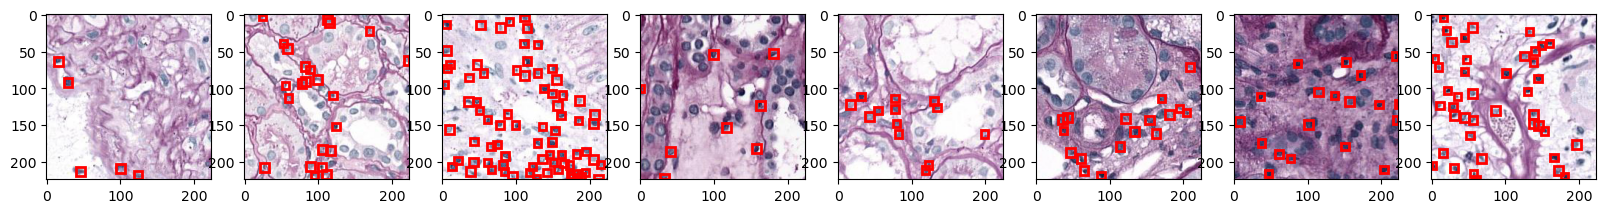

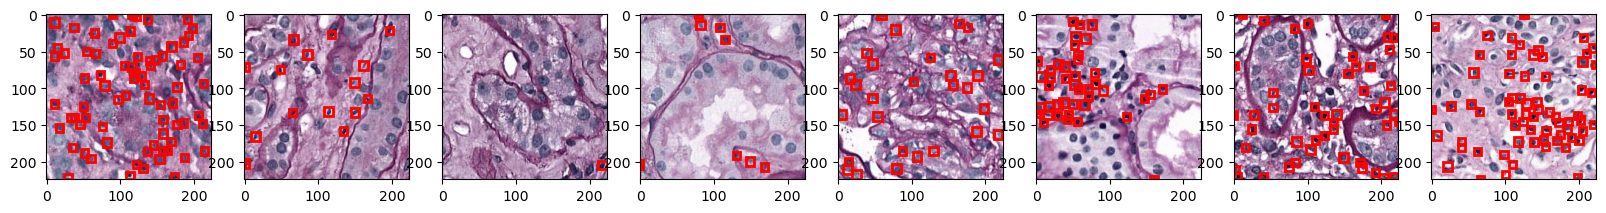

In [6]:
batch_dicts = next(training_batch_generator)

for _ in range(2):
    batch_dicts = next(training_batch_generator)
    fig, ax = plt.subplots(1,8, figsize=(20,10))
    for i in range(8):
        patch = batch_dicts[i]['image'].cpu().detach().numpy().transpose(1,2,0).astype('uint8')
        _boxes =  batch_dicts[i]['instances'].gt_boxes.tensor.cpu().detach().numpy()
        _class = batch_dicts[i]['instances'].gt_classes.cpu().detach().numpy()
        boxes = np.ones((len(_boxes), 6))
        boxes[..., :4] = _boxes
        max_width, max_height = batch_dicts[i]['instances'].image_size
        ax[i].imshow(patch)
        plot_boxes(boxes, max_width=max_width, max_height=max_height, axes=ax[i])
    plt.show()

Creating the output folder for saving the model and results.

In [4]:
output_folder = Path('./outputs')
if not(os.path.isdir(output_folder)): os.mkdir (output_folder) 
cpus = 4

# Train the model

In [ ]:
cfg = get_cfg()
# using faster rcnn architecture
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = () 
cfg.TEST.EVAL_PERIOD = 20  # 200イテレーション毎に評価を実施（例）
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 24]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1.0]]
cfg.MODEL.ROI_HEADS.NAME = "MyFocalROIHeads"

cfg.SOLVER.IMS_PER_BATCH = 256
cfg.SOLVER.BASE_LR = 0.002  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 2000 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.WARMUP_ITERS = 200
cfg.SOLVER.WARMUP_FACTOR = 1.0/1000 
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.CHECKPOINT_PERIOD = 200


cfg.INPUT.RANDOM_FLIP = "horizontal"  # "horizontal", "vertical", "none"など
cfg.INPUT.BRIGHTNESS = 0.8, 1.2
cfg.INPUT.CONTRAST = 0.8, 1.2
cfg.INPUT.SATURATION = 0.8, 1.2
cfg.INPUT.HUE = 0.8, 1.2


cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)


model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

trainer = WholeSlideDectectron2Trainer(cfg, user_config=user_config, cpus=cpus)


trainer.resume_or_load(resume=False)
trainer.train()

Parameter Count:
103959578
[12/12 21:41:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
 

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  linear.{bias, weight}


[12/12 21:41:43 d2.engine.train_loop]: Starting training from iteration 0


/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647382455/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/12 21:43:02 d2.utils.events]:  eta: 1:55:29  iter: 19  total_loss: 1.307  loss_cls: 0.4364  loss_box_reg: 0.05174  loss_rpn_cls: 0.7012  loss_rpn_loc: 0.143    time: 3.5151  last_time: 3.4808  data_time: 0.5145  last_data_time: 0.0859   lr: 0.00019181  max_mem: 39502M
[12/12 21:44:13 d2.utils.events]:  eta: 1:53:46  iter: 39  total_loss: 1.123  loss_cls: 0.3523  loss_box_reg: 0.07633  loss_rpn_cls: 0.6087  loss_rpn_loc: 0.09167    time: 3.5059  last_time: 3.4751  data_time: 0.0898  last_data_time: 0.0876   lr: 0.00039161  max_mem: 39502M
[12/12 21:45:22 d2.utils.events]:  eta: 1:52:35  iter: 59  total_loss: 0.9416  loss_cls: 0.2779  loss_box_reg: 0.07966  loss_rpn_cls: 0.5012  loss_rpn_loc: 0.0823    time: 3.4970  last_time: 3.4972  data_time: 0.0977  last_data_time: 0.1050   lr: 0.00059141  max_mem: 39502M
[12/12 21:46:34 d2.utils.events]:  eta: 1:51:40  iter: 79  total_loss: 0.8492  loss_cls: 0.248  loss_box_reg: 0.09081  loss_rpn_cls: 0.4286  loss_rpn_loc: 0.07731    time: 3.517

Evaluation.

In [7]:
cfg = get_cfg()

cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("detection_dataset2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[8, 16, 24]]
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[1.0]]

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.GAMMA = 0.5

cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.1



cfg.OUTPUT_DIR = str(output_folder)
output_folder.mkdir(parents=True, exist_ok=True)

cfg.MODEL.WEIGHTS = os.path.join(output_folder, "model_final.pth")

model = build_model(cfg)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter Count:\n" + str(pytorch_total_params))

Parameter Count:
103959578


Visualizing a sample batch.

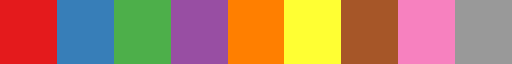

In [14]:
plt.get_cmap('Set1')

[12/08 18:42:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from outputs/model_final.pth ...


/home/jubuntu/anaconda3/envs/monkey/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_loca

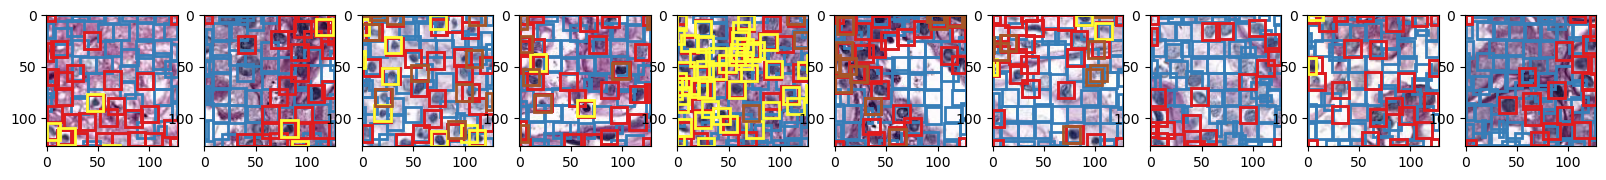

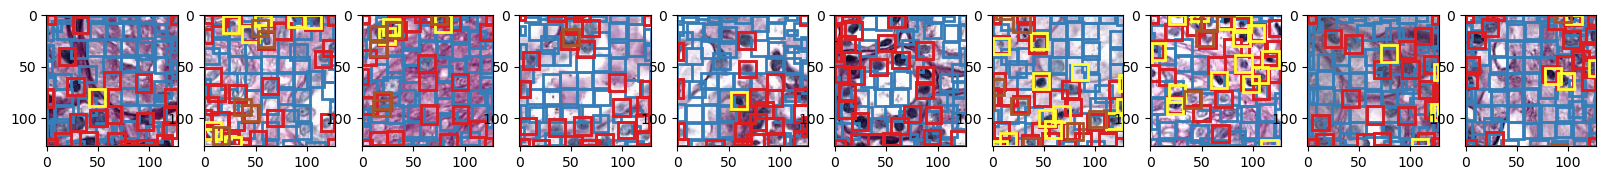

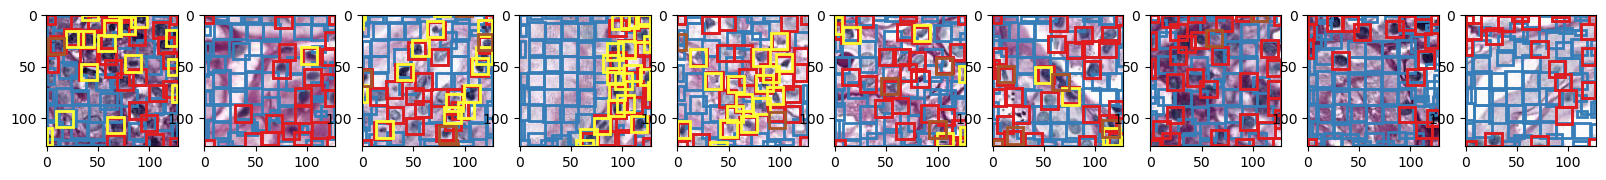

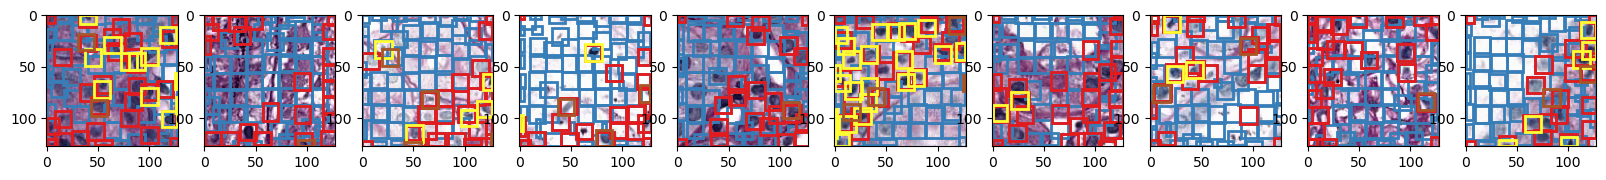

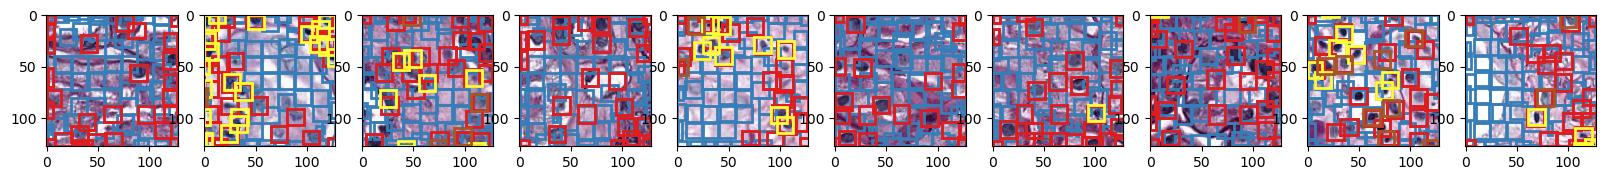

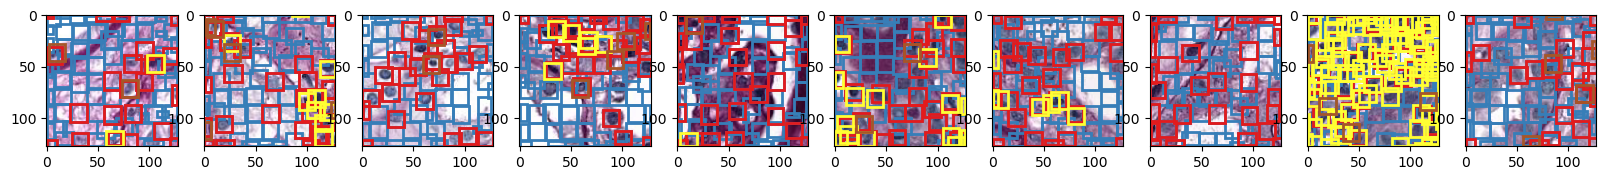

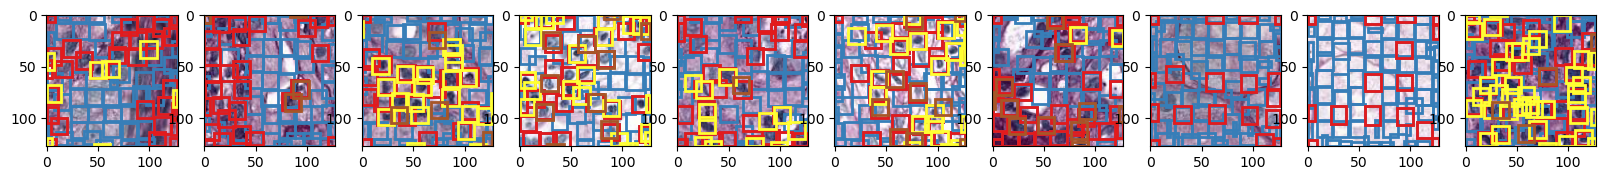

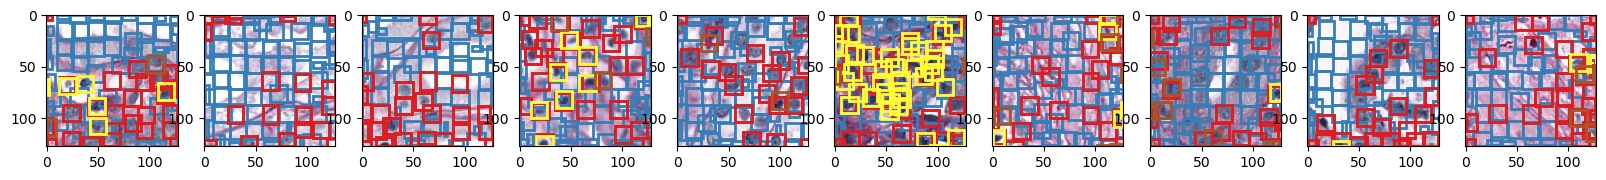

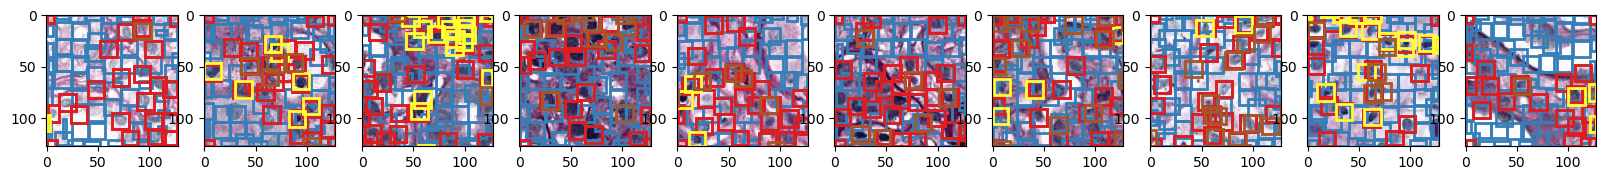

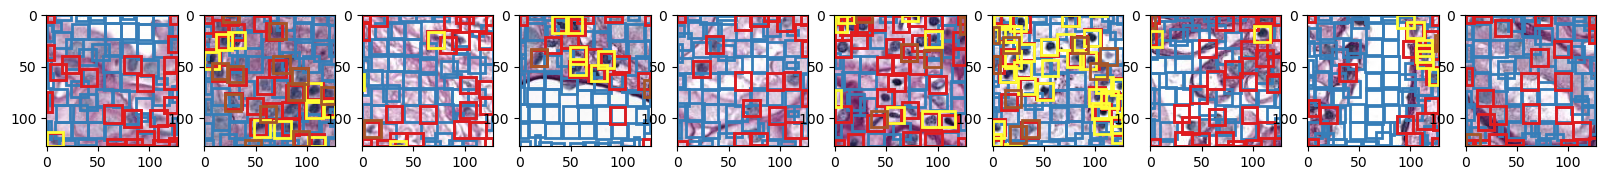

In [13]:
predictor = Detectron2DetectionPredictor(cfg)
class_threshold = {"lymphocyte": 0.6, "monocyte": 0.25}
with create_batch_iterator(
    user_config=user_config,
    mode='training',
    cpus=4,
) as training_batch_generator:
    for _ in range(10):
        fig, ax = plt.subplots(1,10, figsize=(20,10))
        batch_x, batch_y, info = next(training_batch_generator)
        predicted_batch = predictor.predict_on_batch(batch_x)
        for i in range(10):
            patch = batch_x[i]
            boxes =  np.array(predicted_batch[i]['boxes'])
            confidences = predicted_batch[i]['confidences']
            classes = predicted_batch[i]['classes'] 
            boxes[:, 4] = list(np.array(classes))
            
            gt_boxes = batch_y[i]
            gt_boxes[:, 4] +=4

            filtered_boxes = []
            for box, confidence in zip(boxes, confidences):
                if confidence > 0.3:
                    filtered_boxes.append(box)
            for gt_box in gt_boxes:
                filtered_boxes.append(gt_box)

            ax[i].imshow(patch)
            plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[i],color_map=plt.get_cmap('Set1'))
            # ax[i].imshow(patch)
            # plot_boxes(filtered_boxes, max_width=64, max_height=64, axes=ax[i])
        plt.show()